## SVM

In [1]:
import pandas as pd

df = pd.read_csv('mbti.csv', index_col=None) 
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


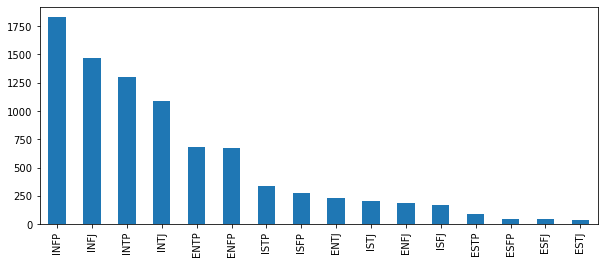

In [2]:
# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,4))
df["type"].value_counts().plot(kind='bar');

In [3]:
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|')
URL_RE = re.compile('(\w+:\/\/\S+)|^rt|http.+?')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = text.replace("|||"," ")
    # text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    # text = BAD_SYMBOLS_RE.sub('', text) 
    # text = URL_RE.sub('urladd',text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df['posts'] = df['posts'].apply(clean_text)
df

,type,posts
0,INFJ,enfp intj moments sportscenter top ten plays p...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else heck dele...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


In [5]:
df.to_csv("mbti_basic_cleaned_dataset.csv",index=False)

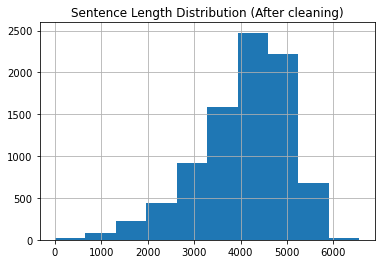

count    8675.000000
mean     4070.981210
std       979.822388
min         0.000000
25%      3517.000000
50%      4239.000000
75%      4784.500000
max      6559.000000
dtype: float64

In [6]:
posts_len = [len(x) for x in df.posts]
pd.Series(posts_len).hist()
plt.title("Sentence Length Distribution (After cleaning)")
plt.show()
pd.Series(posts_len).describe()

In [11]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 9.6 MB/s eta 0:00:01              | 706 kB 9.6 MB/s eta 0:00:03MB/s eta 0:00:01███████████████████████▌      | 19.2 MB 9.6 MB/s eta 0:00:01�██▋| 23.7 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 6.8 MB/s  eta 0:00:01


In [12]:
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.posts, df["type"], random_state=10, 
                                                    test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [14]:
from gensim.models import doc2vec
from tqdm import tqdm
vector_size = 300
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=vector_size, negative=5, min_count=1, alpha=0.065, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 8675/8675 [00:00<00:00, 2490798.69it/s]


In [15]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 8675/8675 [00:00<00:00, 3472238.50it/s]


In [16]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [17]:
import numpy as np
train_vectors_dbow = get_vectors(model_dbow, len(X_train), vector_size, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), vector_size, 'Test')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  """


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC(C=10, gamma='auto', kernel='rbf')
model.fit(train_vectors_dbow, y_train)
y_pred = model.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5816365731847868
              precision    recall  f1-score   support

        ENFJ       0.28      0.23      0.26        47
        ENFP       0.54      0.64      0.59       193
        ENTJ       0.42      0.34      0.38        83
        ENTP       0.50      0.58      0.54       190
        ESFJ       1.00      0.07      0.12        15
        ESFP       0.17      0.07      0.10        15
        ESTJ       0.00      0.00      0.00        14
        ESTP       0.64      0.27      0.38        26
        INFJ       0.58      0.67      0.62       435
        INFP       0.65      0.72      0.69       559
        INTJ       0.58      0.58      0.58       337
        INTP       0.60      0.65      0.62       379
        ISFJ       0.71      0.32      0.44        47
        ISFP       0.47      0.26      0.34        88
        ISTJ       0.54      0.32      0.40        60
        ISTP       0.65      0.34      0.45       115

    accuracy                           0.58      260

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
